In [44]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import color, filters, morphology, measure
from skimage.util import img_as_ubyte
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings("ignore")


# Initial data loading

In [45]:
data=pd.read_csv("../data/HAM10000_metadata.csv")

In [46]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [47]:
data=data.dropna()

In [48]:
data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [49]:
print(data['dx'].value_counts())

dx
nv       6660
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [50]:
balanced_df = (
    data
    .groupby('dx', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 514), random_state=67))
)

In [51]:
print(balanced_df['dx'].value_counts())

dx
bcc      514
bkl      514
mel      514
nv       514
akiec    327
vasc     142
df       115
Name: count, dtype: int64


In [52]:
balanced_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
9698,HAM_0001499,ISIC_0031929,akiec,histo,65.0,male,lower extremity
9999,HAM_0000356,ISIC_0030655,akiec,histo,60.0,female,face
9900,HAM_0000005,ISIC_0024579,akiec,histo,75.0,female,lower extremity
9805,HAM_0007131,ISIC_0031692,akiec,histo,60.0,male,back
9711,HAM_0002745,ISIC_0024562,akiec,histo,75.0,male,chest


# Preprocess & Feature Extraction

In [53]:
def load_image(path, size=256):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    scale = size / max(h, w)
    new_w, new_h = int(w*scale), int(h*scale)
    img_resized = cv2.resize(img, (new_w, new_h))
    
    # buat canvas square
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    x_offset = (size - new_w) // 2
    y_offset = (size - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
    
    return canvas


In [54]:
def dullrazor(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    img_inpaint = cv2.inpaint(img_rgb, mask, 3, cv2.INPAINT_TELEA)
    return img_inpaint


In [55]:
def denoise(img_rgb):
    return cv2.fastNlMeansDenoisingColored(img_rgb, None, 3, 3, 7, 21)
    

In [56]:
def normalize_color(img_rgb):
   
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

In [57]:
def segment_otsu_gray(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    thresh = filters.threshold_otsu(gray)
    mask = (gray < thresh).astype(np.uint8)
    mask = morphology.remove_small_holes(mask.astype(bool), 200).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), 200).astype(np.uint8)
    return mask


In [58]:
def segment_otsu(img_rgb):
    # 1. TWEAK: Extract only the BLUE channel (index 2 in RGB)
    # This acts as a high-contrast filter for skin lesions
    b_channel = img_rgb[:, :, 2]
    
    # 2. OPTIONAL: Handle dark corners (Vignetting) common in microscope images
    # If the corners are black, Otsu might select them instead of the mole.
    # We create a circular mask to ignore the very edges.
    h, w = b_channel.shape
    center = (w // 2, h // 2)
    radius = int(min(h, w) * 0.8 / 2) # Keep inner 90%
    circular_mask = np.zeros_like(b_channel, dtype=np.uint8)
    cv2.circle(circular_mask, center, radius, 255, -1)
    
    # Apply the circular mask to the blue channel (make outside pixels bright so they aren't 'dark lesion')
    b_channel_masked = b_channel.copy()
    b_channel_masked[circular_mask == 0] = 255 
    
    # 3. Apply Otsu Thresholding on the Blue Channel
    thresh = filters.threshold_otsu(b_channel_masked)
    
    # Lesions are darker than the threshold
    mask = (b_channel_masked < thresh).astype(np.uint8)
    
    # 4. Cleaning (Morphology) - Increased size to remove hairs/dots
    # Remove small white holes inside the blob
    mask = morphology.remove_small_holes(mask.astype(bool), area_threshold=500).astype(np.uint8)
    # Remove small random white dots outside the blob
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=500).astype(np.uint8)
    
    return mask

In [59]:
def segment_otsu_before(img_rgb):
    # Use the Blue channel instead of standard Grayscale, lesions usually have higher contrast in the Blue channel
    b_channel = img_rgb[:, :, 2]  
    # Apply Otsu on the inverted Blue channel (or just < thresh)
    thresh = filters.threshold_otsu(b_channel)
    # Lesions are dark in Blue, so they are < thresh
    mask = (b_channel < thresh).astype(np.uint8)
    
    # Keep your original morphological cleaning
    mask = morphology.remove_small_holes(mask.astype(bool), 200).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), 200).astype(np.uint8)
    
    return mask

In [60]:
def extract_features(img_rgb, mask):
    features = []

    gray = img_as_ubyte(color.rgb2gray(img_rgb))
    glcm = graycomatrix(gray, distances=[1, 3, 5], angles=[0,np.pi/4,np.pi/2], symmetric=True, normed=True)
    for prop in ['contrast', 'energy', 'homogeneity', 'correlation']:
        features.append(graycoprops(glcm, prop).mean())

    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    features.append(lbp.mean())

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    features += list(hsv.mean(axis=(0,1)))
    features += list(img_rgb.mean(axis=(0,1)))
    features += list(img_rgb.std(axis=(0,1)))

    if mask is not None:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            c = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            circularity = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0
            features.append(circularity)
            M = cv2.moments(c)
            eccentricity = ((M['mu20'] - M['mu02'])**2 - 4*(M['mu11']**2))/((M['mu20']+M['mu02'])**2) if (M['mu20']+M['mu02'])!=0 else 0
            features.append(float(eccentricity))
            hull = cv2.convexHull(c)
            solidity = area / cv2.contourArea(hull) if cv2.contourArea(hull)>0 else 0
            features.append(solidity)
        else:
            features += [0,0,0]

    return features

In [61]:
def process_image(path, size=256):
    img = load_image(path, size)
    img = dullrazor(img)
    img = denoise(img)
    img = normalize_color(img)
    mask = segment_otsu(img)
    feats = extract_features(img, mask)
    return feats


# Model

In [62]:
IMAGES_DIR = "../data/raw"
SIZE = 256

df = balanced_df
X, y = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMAGES_DIR, row['image_id'] + ".jpg")
    if not os.path.exists(img_path):
        print("File not found:", img_path)
        continue
    feats = process_image(img_path, SIZE)
    X.append(feats)
    y.append(row['dx'])

X = np.array(X)
y = np.array(y)

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

smote = SMOTE(random_state=67, k_neighbors=5)
X, y = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

svm = SVC(
    kernel="rbf",
    C=3,
    gamma="scale",
    probability=True,
    class_weight="balanced"
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=67
)

model = VotingClassifier(
    estimators=[
        ("svm", svm),
        ("xgb", xgb)
    ],
    voting="soft"
)

model.fit(X_train, y_train)

# Predict & report
pred = model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred))

100%|██████████| 2640/2640 [39:42<00:00,  1.11it/s]



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       102
           1       0.49      0.41      0.45       103
           2       0.42      0.33      0.37       103
           3       0.64      0.84      0.73       103
           4       0.49      0.44      0.46       103
           5       0.77      0.64      0.70       103
           6       0.76      0.84      0.80       103

    accuracy                           0.59       720
   macro avg       0.58      0.59      0.58       720
weighted avg       0.58      0.59      0.58       720


Confusion Matrix:
[[64 13  8  8  2  0  7]
 [24 42 10 14  7  1  5]
 [ 8 15 34 11 19 10  6]
 [ 7  1  5 87  2  1  0]
 [14  8 18  8 45  8  2]
 [ 4  3  4  2 17 66  7]
 [ 5  3  2  6  0  0 87]]


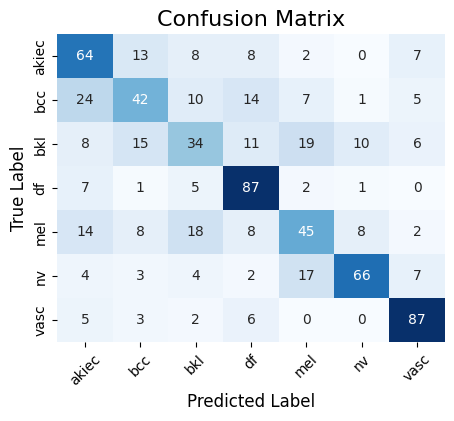

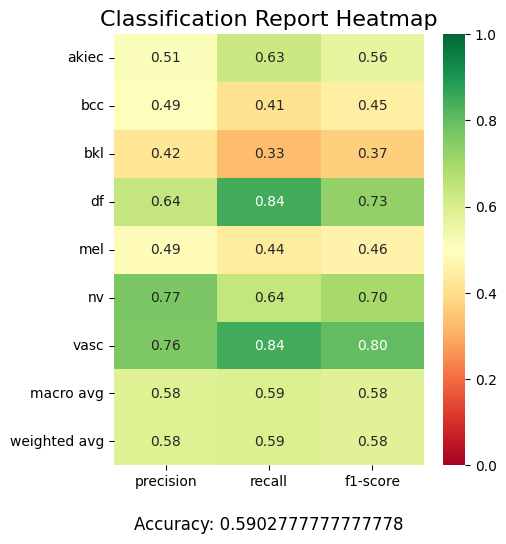

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    
    # heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.savefig("../output/confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

# Classification report
def plot_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    result_accuracy = report['accuracy']
    if 'accuracy' in df_report.index:
        df_report = df_report.drop('accuracy')
    
    plt.figure(figsize=(5, len(classes) * 0.8))
    
    # heatmap
    sns.heatmap(df_report.iloc[:, :-1], annot=True, cmap='RdYlGn', fmt='.2f', vmin=0.0, vmax=1.0)
    
    plt.title('Classification Report Heatmap', fontsize=16)
    plt.yticks(rotation=0)
    plt.text(0.5, -0.15, f"Accuracy: {result_accuracy}", ha='center', transform=plt.gca().transAxes, fontsize=12)
    plt.savefig("../output/classification_report.png", dpi=300, bbox_inches='tight')
    plt.show()

class_names = le.classes_ 

plot_confusion_matrix(y_test, pred, class_names)
plot_classification_report(y_test, pred, class_names)

In [73]:
import joblib

joblib.dump({
    "model": model,      
    "scaler": scaler,
    "label_encoder": le
}, "../output/skin_cancer_ensemble.joblib")

['../output/skin_cancer_ensemble.joblib']

# Preprocessing & Feature Extraction Visualization

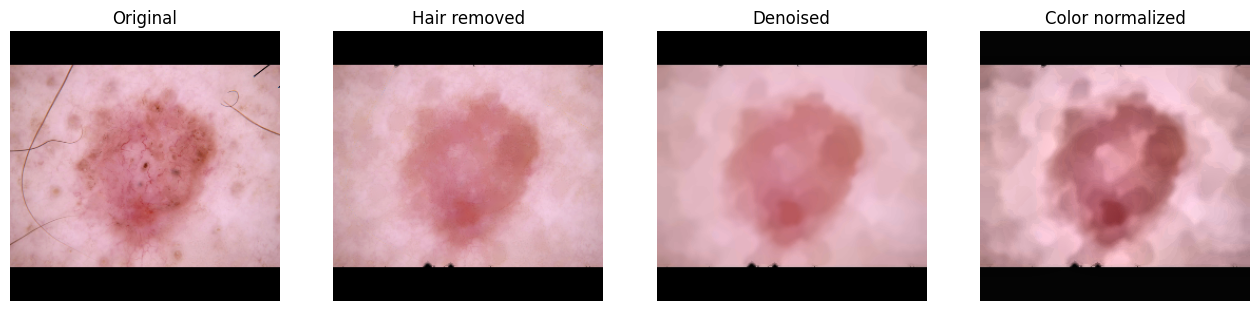

In [83]:
# Visualisasi preprocessing
img = load_image("../data/raw/ISIC_0024332.jpg")
img_dr = dullrazor(img)
img_dn = denoise(img_dr)
img_cn = normalize_color(img_dn)

fig, axes = plt.subplots(1, 4, figsize=(16,4))
axes[0].imshow(img); axes[0].set_title("Original")
axes[1].imshow(img_dr); axes[1].set_title("Hair removed")
axes[2].imshow(img_dn); axes[2].set_title("Denoised")
axes[3].imshow(img_cn); axes[3].set_title("Color normalized")
for ax in axes:
    ax.axis('off')
plt.savefig("../output/preprocessing_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

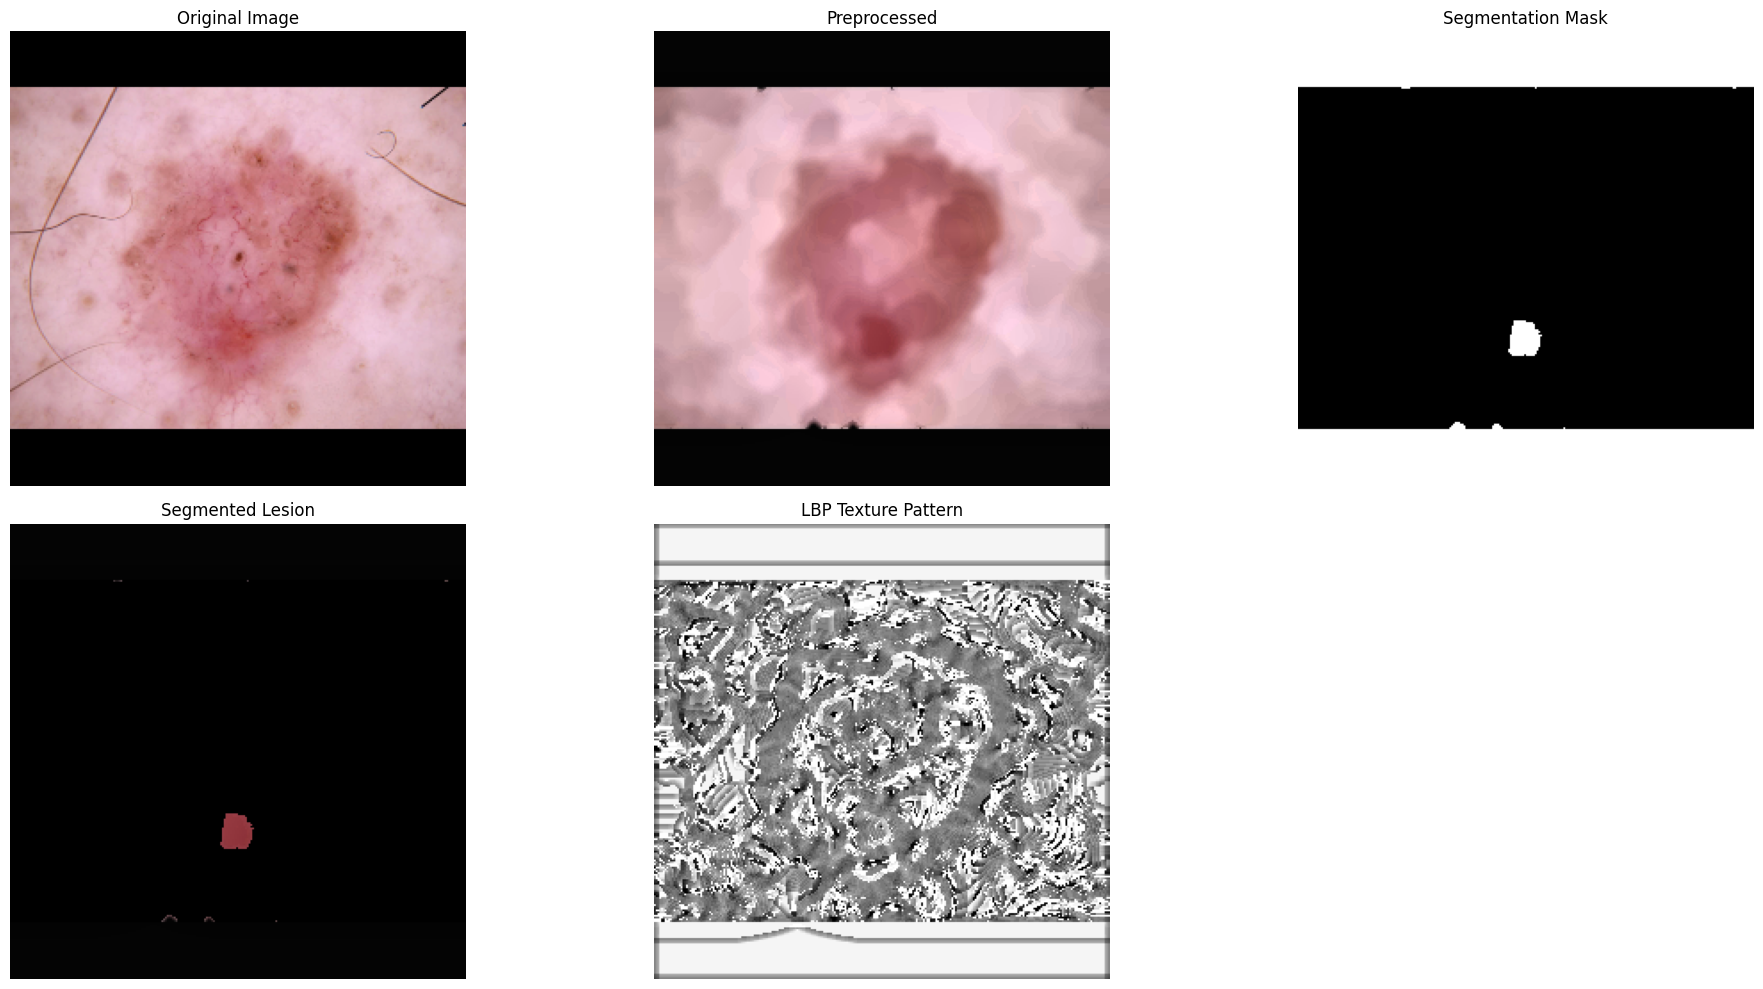

In [84]:
# Visualisasi feature extraction dengan segmentation gray (1st version)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern

img_path = "../data/raw/ISIC_0024332.jpg"  
if not os.path.exists(img_path):
    print(f"Image not found at {img_path}, please check path.")
else:
    
    # preprocess
    original = load_image(img_path)
    img_prep = dullrazor(original)
    img_prep = denoise(img_prep)
    img_prep = normalize_color(img_prep)
    
    # segmentation
    mask = segment_otsu_gray(img_prep) 
    
    # LBP Texture
    gray = cv2.cvtColor(img_prep, cv2.COLOR_RGB2GRAY)
    lbp_image = local_binary_pattern(gray, 24, 3, method='uniform')
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # Original vs Preprocessed (Color normalization + hair removal + denoising)
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(img_prep)
    plt.title("Preprocessed")
    plt.axis('off')
    
    # Segmentation Mask
    plt.subplot(2, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    # Overlay (Mask on Image)
    plt.subplot(2, 3, 4)
    overlay = img_prep.copy()
    overlay[mask == 0] = 0 
    plt.imshow(overlay)
    plt.title("Segmented Lesion")
    plt.axis('off')

    # LBP Texture
    plt.subplot(2, 3, 5)
    plt.imshow(lbp_image, cmap='gray')
    plt.title("LBP Texture Pattern")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("../output/feature_extraction_visualization_segmentation_gray.png", dpi=300, bbox_inches='tight')
    plt.show()

^ Segmentationnya kurang baik, oleh karena itu coba diganti dengan metode lain untuk load imagenya. Tidak menggunakan grayscale, namun diambil channel bluenya saja.
Channel blue bisa mendapatkan hasil yang lebih baik, karena akan memberikan kontras yang lebih baik. Lesion yang ada di kulit memiliki warna yang cenderung lebih merah, sehingga ketika mengambil channel blue saja akan memberikan contrast yang paling baik.

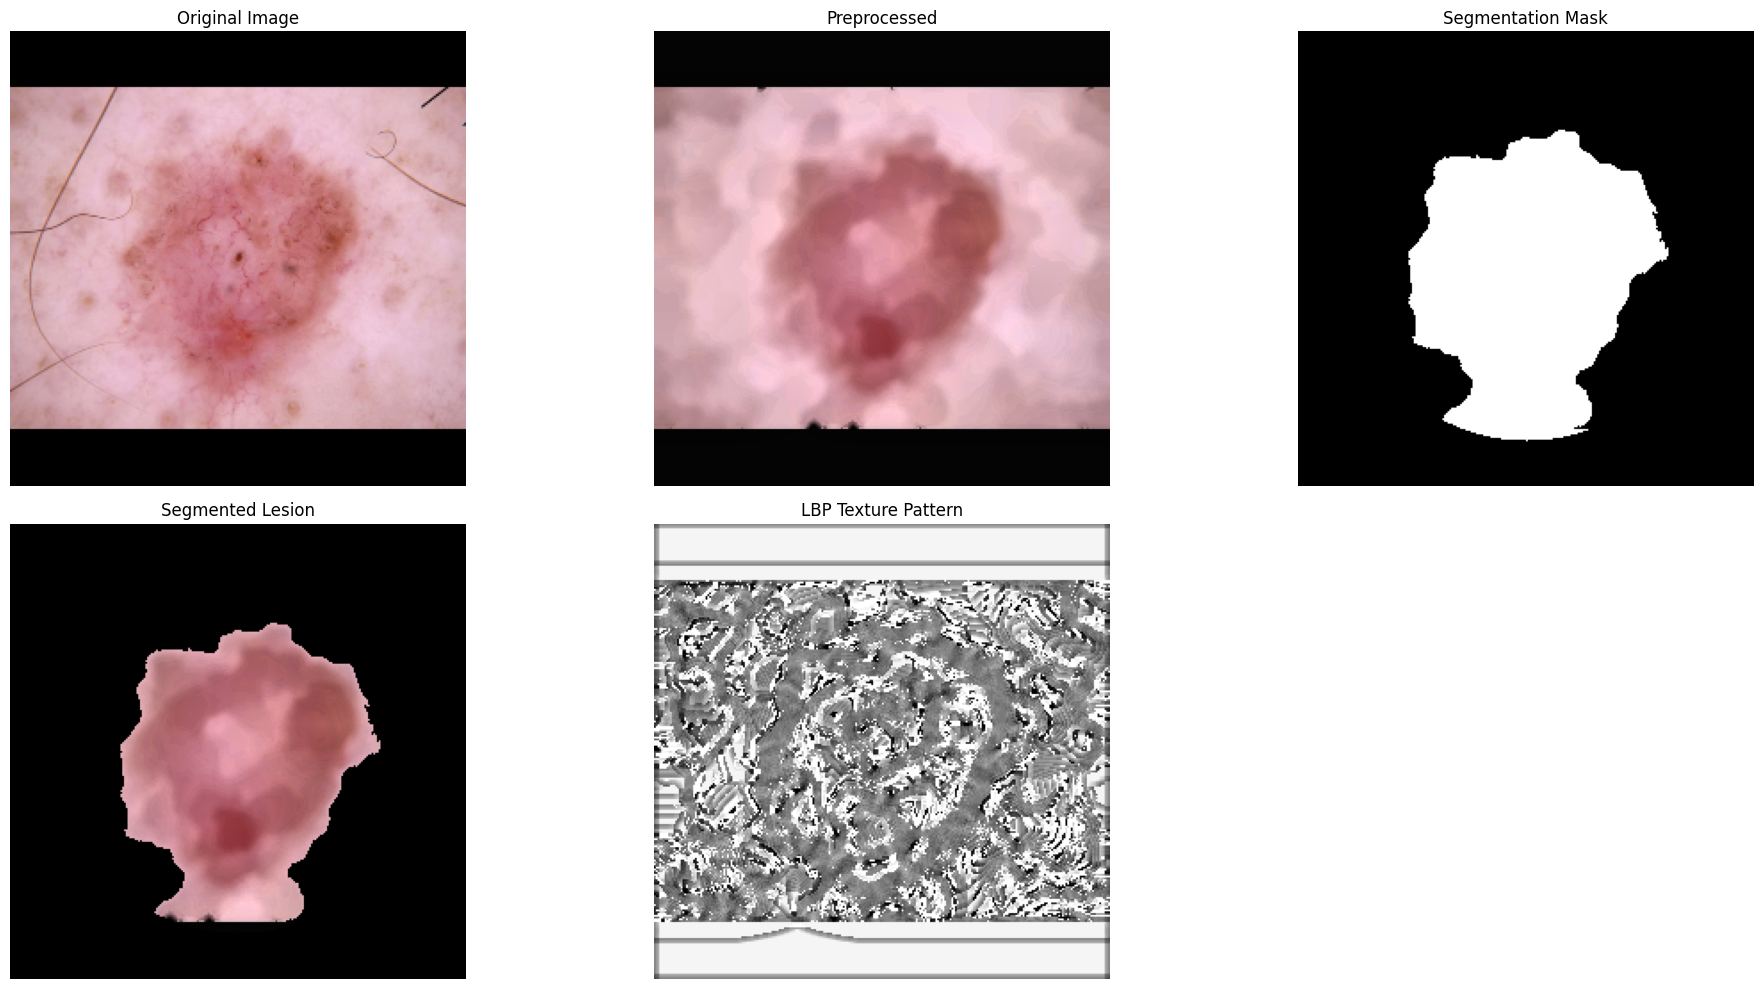

In [85]:
# Visualisasi feature extraction dengan segmentation blue (final version)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern

img_path = "../data/raw/ISIC_0024332.jpg"  
if not os.path.exists(img_path):
    print(f"Image not found at {img_path}, please check path.")
else:
    
    # preprocess
    original = load_image(img_path)
    img_prep = dullrazor(original)
    img_prep = denoise(img_prep)
    img_prep = normalize_color(img_prep)
    
    # segmentation
    mask = segment_otsu(img_prep) 
    
    # LBP Texture
    gray = cv2.cvtColor(img_prep, cv2.COLOR_RGB2GRAY)
    lbp_image = local_binary_pattern(gray, 24, 3, method='uniform')
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # Original vs Preprocessed (Color normalization + hair removal + denoising)
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(img_prep)
    plt.title("Preprocessed")
    plt.axis('off')
    
    # Segmentation Mask
    plt.subplot(2, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    # Overlay (Mask on Image)
    plt.subplot(2, 3, 4)
    overlay = img_prep.copy()
    overlay[mask == 0] = 0 
    plt.imshow(overlay)
    plt.title("Segmented Lesion")
    plt.axis('off')

    # LBP Texture
    plt.subplot(2, 3, 5)
    plt.imshow(lbp_image, cmap='gray')
    plt.title("LBP Texture Pattern")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("../output/feature_extraction_visualization_segmentation_blue.png", dpi=300, bbox_inches='tight')
    plt.show()